In [1]:
from sklearn import tree  
from sklearn.externals import joblib
import pydotplus
from sklearn.datasets import load_iris
import collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import itertools
#import graphviz 
%matplotlib inline

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90,fontsize=16)
    plt.yticks(tick_marks, classes,fontsize=16)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=16)
    plt.xlabel('Predicted label',fontsize=16)
    return cm

def get_dataset(file_name,data_class_name_num,data_class_name):
    data = pd.read_csv(file_name)
    data = data.reset_index(drop=True)
    data = data.dropna()
    X = data.iloc[:,0:4]
    X = X.reset_index(drop=True)
    X = X.dropna()
    Y = data.iloc[:,-1]
    Y = Y.replace(data_class_name_num, data_class_name)
    Y = Y.reset_index(drop=True)
    Y = Y.dropna()

    min_max_scaler = preprocessing.MinMaxScaler()
    values = X.values
    values_scaled = min_max_scaler.fit_transform(values)
#     X = pd.DataFrame(values_scaled)
#     print(df.head())
    return X,Y

def calc_stat(clf,X,Y):
    score = clf.score(X,Y)
    y_true = Y;
    y_pred = clf.predict(X) 
    precision,recall,fbeta_score,support = precision_recall_fscore_support(y_true, 
                                                                       y_pred, 
                                                                       beta=1.0, 
                                                                       labels=None, 
                                                                       pos_label=1, 
                                                                       average=None, 
                                                                       warn_for=('precision', 'recall', 'f-score'), 
                                                                       sample_weight=None)
    return score,precision,recall,fbeta_score,support 


In [10]:
own_data = True
experiment = 1
no_off_class = 5
data_feature_names = [ 'altitude', 'vel_x', 'vel_y', 'vel_z' ]
data_class_name_num = [1, 2, 3, 4, 5]
data_class_name = ['Hold', 'Takeoff', 'Hover', 'Search', 'Land']

data_feature_names_gtri = [ 'roll', 'pitch', 'yaw', 'rollspeed','pitchspeed','yawspeed', 'xacc', 'yacc', 'zacc']
data_class_name_num_gtri = [0, 1, 2, 3]
data_class_name_gtri = ['Hold', 'Fly Orbit and Observe', 'Fly Search Pattern', 'Survey Target']


datagtri = pd.read_csv('GTRIdataset.csv')
datagtri = datagtri.dropna()
gtriX = datagtri.iloc[:,1:10]
gtriX = gtriX.reset_index(drop=True)
gtriX = gtriX.dropna()
gtriY = datagtri.iloc[:,10]
gtriY = gtriY.replace(data_class_name_num_gtri, data_class_name_gtri)
gtriY = gtriY.reset_index(drop=True)
gtriY = gtriY.dropna()


intelX,intelY = get_dataset('intelDroneData.csv',data_class_name_num,data_class_name)

print('Real Data intel: ', 'Hold: ', len(intelY[intelY=='Hold']),
      ' Takeoff: ', len(intelY[intelY=='Takeoff']),
      ' Hover: ', len(intelY[intelY=='Hover']),
      ' Search: ', len(intelY[intelY=='Search']),
      ' Land: ', len(intelY[intelY=='Land']),
      ' Total: ', len(intelY))

arX,arY = get_dataset('arDroneData.csv',data_class_name_num,data_class_name)

print('Real Data ar: ', 'Hold: ', len(arY[arY=='Hold']),
      ' Takeoff: ', len(arY[arY=='Takeoff']),
      ' Hover: ', len(arY[arY=='Hover']),
      ' Search: ', len(arY[arY=='Search']),
      ' Land: ', len(arY[arY=='Land']))

inarX,inarY = get_dataset('intelardata.csv',data_class_name_num,data_class_name)
inarsimX,inarsimY = get_dataset('intelarsimdata.csv',data_class_name_num,data_class_name)

simirisX,simirisY = get_dataset('datasetiris.csv',data_class_name_num,data_class_name)
simsoloX,simsoloY = get_dataset('datasetsolo.csv',data_class_name_num,data_class_name)
simX,simY = get_dataset('gazeboSimulationData.csv',data_class_name_num,data_class_name)

simconcatX = pd.concat([simirisX,simsoloX,intelX],axis=0)
simconcatY = pd.concat([simirisY,simsoloY,intelY],axis=0)

simonlyconcatX = pd.concat([simirisX,simsoloX],axis=0)
simonlyconcatY = pd.concat([simirisY,simsoloY],axis=0)

# simX,simY = simsoloX,simsoloY
# simX,simY = simirisX,simirisY
# simX,simY = simconcatX,simconcatY
print('Simulation Data: ', 'Hold: ', len(simY[simY=='Hold']),
      ' Takeoff: ', len(simY[simY=='Takeoff']),
      ' Hover: ', len(simY[simY=='Hover']),
      ' Search: ', len(simY[simY=='Search']),
      ' Land: ', len(simY[simY=='Land']),
      ' Total: ', len(simY))

print('Simulation iris Data: ', 'Hold: ', len(simirisY[simirisY=='Hold']),
      ' Takeoff: ', len(simirisY[simirisY=='Takeoff']),
      ' Hover: ', len(simirisY[simirisY=='Hover']),
      ' Search: ', len(simirisY[simirisY=='Search']),
      ' Land: ', len(simirisY[simirisY=='Land']),
      ' Total: ', len(simirisY))

print('Simulation solo Data: ', 'Hold: ', len(simsoloY[simsoloY=='Hold']),
      ' Takeoff: ', len(simsoloY[simsoloY=='Takeoff']),
      ' Hover: ', len(simsoloY[simsoloY=='Hover']),
      ' Search: ', len(simsoloY[simsoloY=='Search']),
      ' Land: ', len(simsoloY[simsoloY=='Land']),
      ' Total: ', len(simsoloY))

print('Simulation concat Data: ', 'Hold: ', len(simconcatY[simconcatY=='Hold']),
      ' Takeoff: ', len(simconcatY[simconcatY=='Takeoff']),
      ' Hover: ', len(simconcatY[simconcatY=='Hover']),
      ' Search: ', len(simconcatY[simconcatY=='Search']),
      ' Land: ', len(simconcatY[simconcatY=='Land']),
      ' Total: ', len(simconcatY))

Real Data intel:  Hold:  9862  Takeoff:  501  Hover:  1767  Search:  1251  Land:  598  Total:  13979
Real Data ar:  Hold:  4633  Takeoff:  4308  Hover:  21453  Search:  14447  Land:  2050
Simulation Data:  Hold:  3715  Takeoff:  795  Hover:  1185  Search:  8482  Land:  837  Total:  15014
Simulation iris Data:  Hold:  6323  Takeoff:  684  Hover:  6285  Search:  5597  Land:  995  Total:  19884
Simulation solo Data:  Hold:  11817  Takeoff:  1014  Hover:  4586  Search:  7122  Land:  1472  Total:  26011
Simulation concat Data:  Hold:  28002  Takeoff:  2199  Hover:  12638  Search:  13970  Land:  3065  Total:  59874


Train stat:
Accuracy:  0.9971876850207223
precision:  [0.99263623 0.98874296 0.99860724 1.         1.        ]
recall:  [1.         1.         0.96630728 0.99973781 0.98467967]
Fscore:  [0.99630451 0.99433962 0.98219178 0.99986889 0.9922807 ]
support [ 4633 21453  2050 14447  4308]
Test stat:
Accuracy:  0.9507323568575233
precision:  [0.95251397 0.8503937  0.94117647 0.97206054 0.87671233]
recall:  [0.9884058  0.82442748 0.84210526 0.97775176 0.83116883]
Fscore:  [0.97012802 0.8372093  0.88888889 0.97489784 0.85333333]
Intel stat:
Accuracy:  0.8522068817511982
precision:  [0.9810007  0.78644068 0.40582524 0.5237581  0.42105263]
recall:  [1.         0.26259196 0.34949833 0.7753797  0.81437126]
Fscore:  [0.99040924 0.39372083 0.37556155 0.62520142 0.55510204]
AR stat:
Accuracy:  0.43598984879827685
precision:  [0.80488662 0.71385542 0.22373101 0.39692462 0.29528536]
recall:  [0.98834449 0.02209481 0.33756098 0.98449505 0.11049211]
Fscore:  [0.88723116 0.04286296 0.26910364 0.56575179 0.1

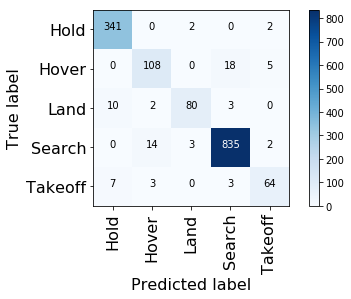

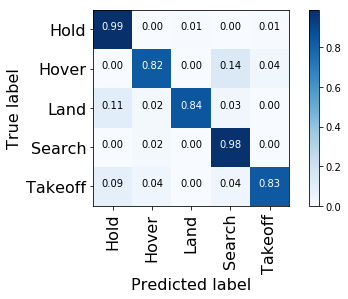

In [3]:
# # to test gtri data
# own_data = False
# dataX = gtriX
# dataY = gtriY
# data_feature_names = data_feature_names_gtri
# data_class_name = data_class_name_gtri

# # to test intel drone data
# dataX = intelX
# dataY = intelY

# # to test ar drone data
# dataX = arX
# dataY = arY

# #to test simulation data
dataX = simX
dataY = simY

# dataX = simirisX
# dataY = simirisY

# dataX = simsoloX
# dataY = simsoloY

#dataX = simconcatX
#dataY = simconcatY

# dataX=inarX
# dataY=inarY

# dataX=inarsimX
# dataY=inarsimY

Noofrun = 1

trainAccuracy = 0
trainPrecision = np.zeros(no_off_class)
trainRecall = np.zeros(no_off_class)
trainF1score = np.zeros(no_off_class)

testAccuracy = 0
testPrecision = np.zeros(no_off_class)
testRecall = np.zeros(no_off_class)
testF1score = np.zeros(no_off_class)

intelAccuracy = 0
intelPrecision = np.zeros(no_off_class)
intelRecall = np.zeros(no_off_class)
intelF1score = np.zeros(no_off_class)

arAccuracy = 0
arPrecision = np.zeros(no_off_class)
arRecall = np.zeros(no_off_class)
arF1score = np.zeros(no_off_class)

soloAccuracy = 0
soloPrecision = np.zeros(no_off_class)
soloRecall = np.zeros(no_off_class)
soloF1score = np.zeros(no_off_class)

irisAccuracy = 0
irisPrecision = np.zeros(no_off_class)
irisRecall = np.zeros(no_off_class)
irisF1score = np.zeros(no_off_class)

#######################
# dataX, testdataX, dataY, testdataY = train_test_split(dataX, dataY, 
#                                                     test_size=0.4, 
#                                                     random_state=np.random.randint(100))
# datap=np.arange(.1,1,.1)
# score0=[]
# score1=[]
# for dp in range(len(datap)):
#     score2=0
#     score3=0
#     for r in range(Noofrun):
#         dataPartision = 1.0 - datap[dp]
#         trainX, testX, trainY, testY = train_test_split(dataX, dataY, 
#                                                     test_size=dataPartision, 
#                                                     random_state=np.random.randint(100))
#         trainX = trainX.reset_index(drop=True)
#         trainX = trainX.dropna()
#         trainY = trainY.reset_index(drop=True)
#         trainY = trainY.dropna()

#         clf = tree.DecisionTreeClassifier(criterion='gini',#'entropy',#'gini', 
#                                       splitter='best', 
#                                       max_depth=None,#default None 
#                                       min_samples_split=2, 
#                                       min_samples_leaf=1, 
#                                       min_weight_fraction_leaf=0.0, 
#                                       max_features=None, 
#                                       random_state=None, 
#                                       max_leaf_nodes=None, 
#                                       min_impurity_decrease=0.0, 
#                                       min_impurity_split=None, 
#                                       class_weight=None, 
#                                       presort=False)                                             


#         clf = clf.fit(trainX, trainY)
#         score,precision,recall,fbeta_score,support = calc_stat(clf,trainX,trainY)
#         score2 += score
#         score,precision,recall,fbeta_score,support = calc_stat(clf,testdataX,testdataY)
#         score3 += score
#     score2 /= Noofrun
#     score0.append(score2)
#     score3 /= Noofrun
#     score1.append(score3)
    

# plt.plot(datap,score0,label='train accuracy',linewidth=3,c='r')
# plt.plot(datap,score1,label='test accuracy',linewidth=3,c='b')
# plt.legend(prop={'size': 18})
# plt.grid()
# plt.xlabel('Fraction of data used for training',fontsize=18)
# plt.ylabel('Percent accuracy',fontsize=18)
# plt.xticks(fontsize=18)
# plt.yticks(fontsize=18)
#######################

for r in range(Noofrun):
#     indx = [i for i in range(len(dataY))]
#     random.shuffle(indx)
    dataPartision = 0.1
#     totaltrainsample = int(dataPartision*len(dataY))
    trainX, testX, trainY, testY = train_test_split(dataX, dataY, 
                                                    test_size=dataPartision, 
                                                    random_state=np.random.randint(100))
#     trainX = dataX.iloc[indx[0:totaltrainsample],:]
    trainX = trainX.reset_index(drop=True)
    trainX = trainX.dropna()
#     trainX = dataY.iloc[indx[0:totaltrainsample]]
    trainY = trainY.reset_index(drop=True)
    trainY = trainY.dropna()

#     testX = dataX.iloc[indx[totaltrainsample:],:]
    testX = testX.reset_index(drop=True)
    testX = testX.dropna()
#     testY = dataY.iloc[indx[totaltrainsample:]]
    testY = testY.reset_index(drop=True)
    testY = testY.dropna()

    clf = tree.DecisionTreeClassifier(criterion='gini',#'entropy',#'gini', 
                                      splitter='best', 
                                      max_depth=None,#default None 
                                      min_samples_split=2, 
                                      min_samples_leaf=1, 
                                      min_weight_fraction_leaf=0.0, 
                                      max_features=None, 
                                      random_state=None, 
                                      max_leaf_nodes=None, 
                                      min_impurity_decrease=0.0, 
                                      min_impurity_split=None, 
                                      class_weight=None, 
                                      presort=False)                                             


    clf = clf.fit(trainX, trainY) 
    # # save the model for future use
    # joblib.dump(clf, 'trainedModel.pkl', protocol=2)
    # # clf = joblib.load('trainedModel.pkl') 

#     trainAccuracy = trainAccuracy + clf.score(trainX, trainY)
#     testAccuracy = testAccuracy + clf.score(testX, testY)
    maxDepth = clf.max_depth
    
    score,precision,recall,fbeta_score,support = calc_stat(clf,trainX,trainY)
    trainAccuracy += score
    trainPrecision += precision
    trainRecall += recall
    trainF1score += fbeta_score
    
    score,precision,recall,fbeta_score,support = calc_stat(clf,testX,testY)
    testAccuracy += score
    testPrecision += precision
    testRecall += recall
    testF1score += fbeta_score
    
    score,precision,recall,fbeta_score,support = calc_stat(clf,intelX,intelY)
    intelAccuracy += score
    intelPrecision += precision
    intelRecall += recall
    intelF1score += fbeta_score
    
    score,precision,recall,fbeta_score,support = calc_stat(clf,arX,arY)
    arAccuracy += score
    arPrecision += precision
    arRecall += recall
    arF1score += fbeta_score
    arsupport = support
    
    score,precision,recall,fbeta_score,support = calc_stat(clf,simirisX,simirisY)
    irisAccuracy += score
    irisPrecision += precision
    irisRecall += recall
    irisF1score += fbeta_score
    
    score,precision,recall,fbeta_score,support = calc_stat(clf,simsoloX,simsoloY)
    soloAccuracy += score
    soloPrecision += precision
    soloRecall += recall
    soloF1score += fbeta_score

# trainAccuracy = trainAccuracy/Noofrun
# testAccuracy = testAccuracy/Noofrun
# print('train accuracy: ', trainAccuracy, ' test accuracy: ', testAccuracy, ' max depth: ', maxDepth)

# if own_data:
#     intelAccuracy = clf.score(intelX, intelY)
#     print('intel accuracy: ', intelAccuracy)

#     simAccuracy = clf.score(simX, simY)
#     print('sim accuracy: ', simAccuracy)
    
#     simirisAccuracy = clf.score(simirisX, simirisY)
#     print('sim iris accuracy: ', simirisAccuracy)
    
#     simsoloAccuracy = clf.score(simsoloX, simsoloY)
#     print('sim solo accuracy: ', simsoloAccuracy)

    
# if experiment == 1 or experiment == 4:
#     testY_pred = clf.predict(testX)
#     y_true = testY
#     y_pred = testY_pred
# elif experiment == 2:
#     testY_pred = clf.predict(intelX)
#     y_true = intelY
#     y_pred = testY_pred
# elif experiment == 3:
#     testY_pred = clf.predict(simX)
#     y_true = simY
#     y_pred = testY_pred
        
# precision,recall,fbeta_score,support = precision_recall_fscore_support(y_true, 
#                                                                        y_pred, 
#                                                                        beta=1.0, 
#                                                                        labels=None, 
#                                                                        pos_label=1, 
#                                                                        average=None, 
#                                                                        warn_for=('precision', 'recall', 'f-score'), 
#                                                                        sample_weight=None)

print('Train stat:')
print('Accuracy: ', trainAccuracy/Noofrun)
print('precision: ', (trainPrecision/Noofrun))
print('recall: ', (trainRecall/Noofrun))
print('Fscore: ', (trainF1score/Noofrun))
print('support', arsupport)

print('Test stat:')
print('Accuracy: ', testAccuracy/Noofrun)
print('precision: ', (testPrecision/Noofrun))
print('recall: ', (testRecall/Noofrun))
print('Fscore: ', (testF1score/Noofrun))

print('Intel stat:')
print('Accuracy: ', intelAccuracy/Noofrun)
print('precision: ', (intelPrecision/Noofrun))
print('recall: ', (intelRecall/Noofrun))
print('Fscore: ', (intelF1score/Noofrun))

print('AR stat:')
print('Accuracy: ', arAccuracy/Noofrun)
print('precision: ', (arPrecision/Noofrun))
print('recall: ', (arRecall/Noofrun))
print('Fscore: ', (arF1score/Noofrun))

print('Iris stat:')
print('Accuracy: ', irisAccuracy/Noofrun)
print('precision: ', (irisPrecision/Noofrun))
print('recall: ', (irisRecall/Noofrun))
print('Fscore: ', (irisF1score/Noofrun))

print('Solo stat:')
print('Accuracy: ', soloAccuracy/Noofrun)
print('precision: ', (soloPrecision/Noofrun))
print('recall: ', (soloRecall/Noofrun))
print('Fscore: ', (soloF1score/Noofrun))

print('Simulation testy Data: ', 'Hold: ', len(testY[testY=='Hold']),
      ' Takeoff: ', len(testY[testY=='Takeoff']),
      ' Hover: ', len(testY[testY=='Hover']),
      ' Search: ', len(testY[testY=='Search']),
      ' Land: ', len(testY[testY=='Land']),
      ' Total: ', len(testY))

y_true = testY
y_pred = clf.predict(testX) 
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)

np.set_printoptions(precision=2)

data_class_name = ['Hold', 'Hover', 'Land', 'Search', 'Takeoff']
# Plot non-normalized confusion matrix
plt.figure()
cm_non_normalized = plot_confusion_matrix(cnf_matrix, classes=data_class_name,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
cm_normalized = plot_confusion_matrix(cnf_matrix, classes=data_class_name, normalize=True,
                      title='Normalized confusion matrix')

plt.show()



Confusion matrix, without normalization
[[341   0   2   0   2]
 [  0 108   0  18   5]
 [ 10   2  80   3   0]
 [  0  14   3 835   2]
 [  7   3   0   3  64]]
Normalized confusion matrix
[[0.99 0.   0.01 0.   0.01]
 [0.   0.82 0.   0.14 0.04]
 [0.11 0.02 0.84 0.03 0.  ]
 [0.   0.02 0.   0.98 0.  ]
 [0.09 0.04 0.   0.04 0.83]]


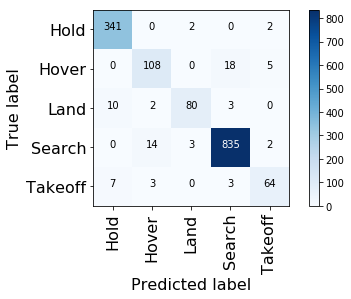

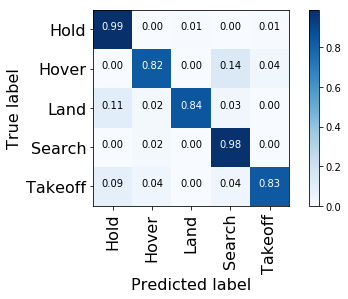

In [4]:
testY_pred = clf.predict(testX)
y_true = testY
y_pred = testY_pred

# # Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)
data_class_name = ['Hold', 'Hover', 'Land', 'Search', 'Takeoff']
# # Plot non-normalized confusion matrix
plt.figure()
cm_non_normalized = plot_confusion_matrix(cnf_matrix, classes=data_class_name,
                       title='Confusion matrix, without normalization')

# # Plot normalized confusion matrix
plt.figure()
cm_normalized = plot_confusion_matrix(cnf_matrix, classes=data_class_name, normalize=True,
                       title='Normalized confusion matrix')

plt.show()

In [5]:
# Visualize data
dot_data = tree.export_graphviz(clf,
                                feature_names=data_feature_names,
                                class_names=data_class_name,
                                out_file=None,
                                max_depth=None,
                                leaves_parallel=False,
                                filled=True,
                                rounded=True,
                                special_characters=True) 
                         
graph = pydotplus.graph_from_dot_data(dot_data)

colors = ('turquoise', 'orange')
edges = collections.defaultdict(list)

for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))

for edge in edges:
    edges[edge].sort()    
    for i in range(2):
        dest = graph.get_node(str(edges[edge][i]))[0]
        dest.set_fillcolor(colors[i])

graph.write_png('tree.png')

True

scenario accuracy:  1.0
precision:  [1. 1. 1. 1. 1.]
recall:  [1. 1. 1. 1. 1.]
Fscore:  [1. 1. 1. 1. 1.]
support [236  49  52 599  64]
Confusion matrix, without normalization
[[236   0   0   0   0]
 [  0  49   0   0   0]
 [  0   0  52   0   0]
 [  0   0   0 599   0]
 [  0   0   0   0  64]]
Normalized confusion matrix
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


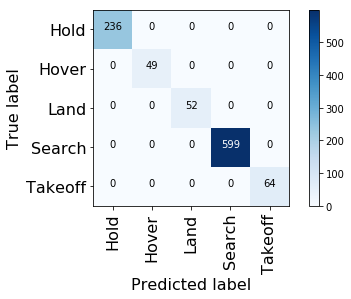

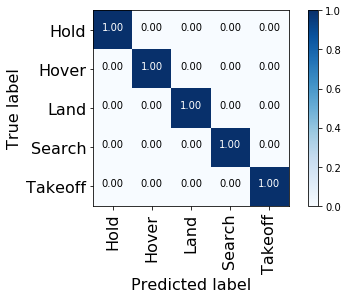

********************************REPORT********************************
The experiment follows the true scenerio  100.0 %.
Details: 
The experiment follows  Hold state     100.0 %,  
			Hover state  100.0 %,  
			Land state    100.0 %,  
			Search state   100.0 %,  
			Takeoff state     100.0 %. 
******************************END REPORT******************************


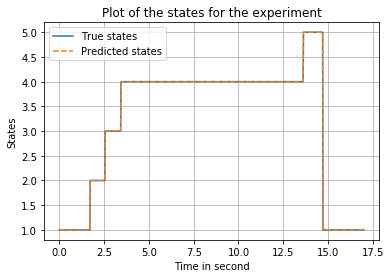

In [6]:
# check a scenerio and generate report
datascenario = pd.read_csv('dataset15.csv')
datascenario = datascenario.dropna()
scenarioX = datascenario.iloc[:,0:4]
scenarioX = scenarioX.reset_index(drop=True)
scenarioX = scenarioX.dropna()
scenarioY = datascenario.iloc[:,-1]
scenarioY = scenarioY.replace(data_class_name_num, data_class_name)
scenarioY = scenarioY.reset_index(drop=True)
scenarioY = scenarioY.dropna()

# scenarioX,scenarioY = simirisX,simirisY
trainX, testX, trainY, testY = train_test_split(scenarioX, scenarioY, 
                                                    test_size=0.1, 
                                                    random_state=np.random.randint(100))
clf = clf.fit(trainX,trainY) 

scenarioY_pred = clf.predict(scenarioX)

scenarioAccuracy = clf.score(scenarioX, scenarioY)
print('scenario accuracy: ', scenarioAccuracy)

y_true = scenarioY
y_pred = scenarioY_pred
        
precision,recall,fbeta_score,support = precision_recall_fscore_support(y_true, 
                                                                       y_pred, 
                                                                       beta=1.0, 
                                                                       labels=None, 
                                                                       pos_label=1, 
                                                                       average=None, 
                                                                       warn_for=('precision', 'recall', 'f-score'), 
                                                                       sample_weight=None)
print('precision: ', precision)
print('recall: ', recall)
print('Fscore: ', fbeta_score)
print('support', support)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

data_class_name = ['Hold', 'Hover', 'Land', 'Search', 'Takeoff']
# Plot non-normalized confusion matrix
plt.figure()
cm_non_normalized = plot_confusion_matrix(cnf_matrix, classes=data_class_name,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
cm_normalized = plot_confusion_matrix(cnf_matrix, classes=data_class_name, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

y_true = y_true.replace(data_class_name, data_class_name_num)
y_pred = pd.DataFrame(y_pred)
y_pred = y_pred.replace(data_class_name, data_class_name_num)
time = np.linspace(start=0,stop=17,num=len(y_true))


reco = []
for i in range(len(data_class_name)):
    if cm_normalized[i,i] != 1.0:
        reco.append(data_class_name[i])

print('********************************REPORT********************************')
print('The experiment follows the true scenerio ', scenarioAccuracy*100,'%.')
print('Details: ')
print('The experiment follows  Hold state    ', round(cm_normalized[0,0]*100,2),'%, ',
                            '\n\t\t\tHover state ', round(cm_normalized[1,1]*100,2),'%, ',
                            '\n\t\t\tLand state   ', round(cm_normalized[2,2]*100,2),'%, ',
                            '\n\t\t\tSearch state  ', round(cm_normalized[3,3]*100,2),'%, ',
                            '\n\t\t\tTakeoff state    ', round(cm_normalized[4,4]*100,2),'%. ')
if reco:
    print('Recommendation: The following states need to be checked, ', reco)
plt.figure()
plt.plot(time, y_true,lw=1.5,label='True states')
plt.plot(time, y_pred,'--',lw=1.5,label='Predicted states')
plt.xlabel('Time in second')
plt.ylabel('States')
plt.title('Plot of the states for the experiment')
plt.legend()
plt.grid()
print('******************************END REPORT******************************')
      

# plt.plot(dataX.iloc[1:1000,3])

(array([ 93.,  94.,  95.,  96.,  97.,  98.,  99., 100., 101.]),
 <a list of 9 Text yticklabel objects>)

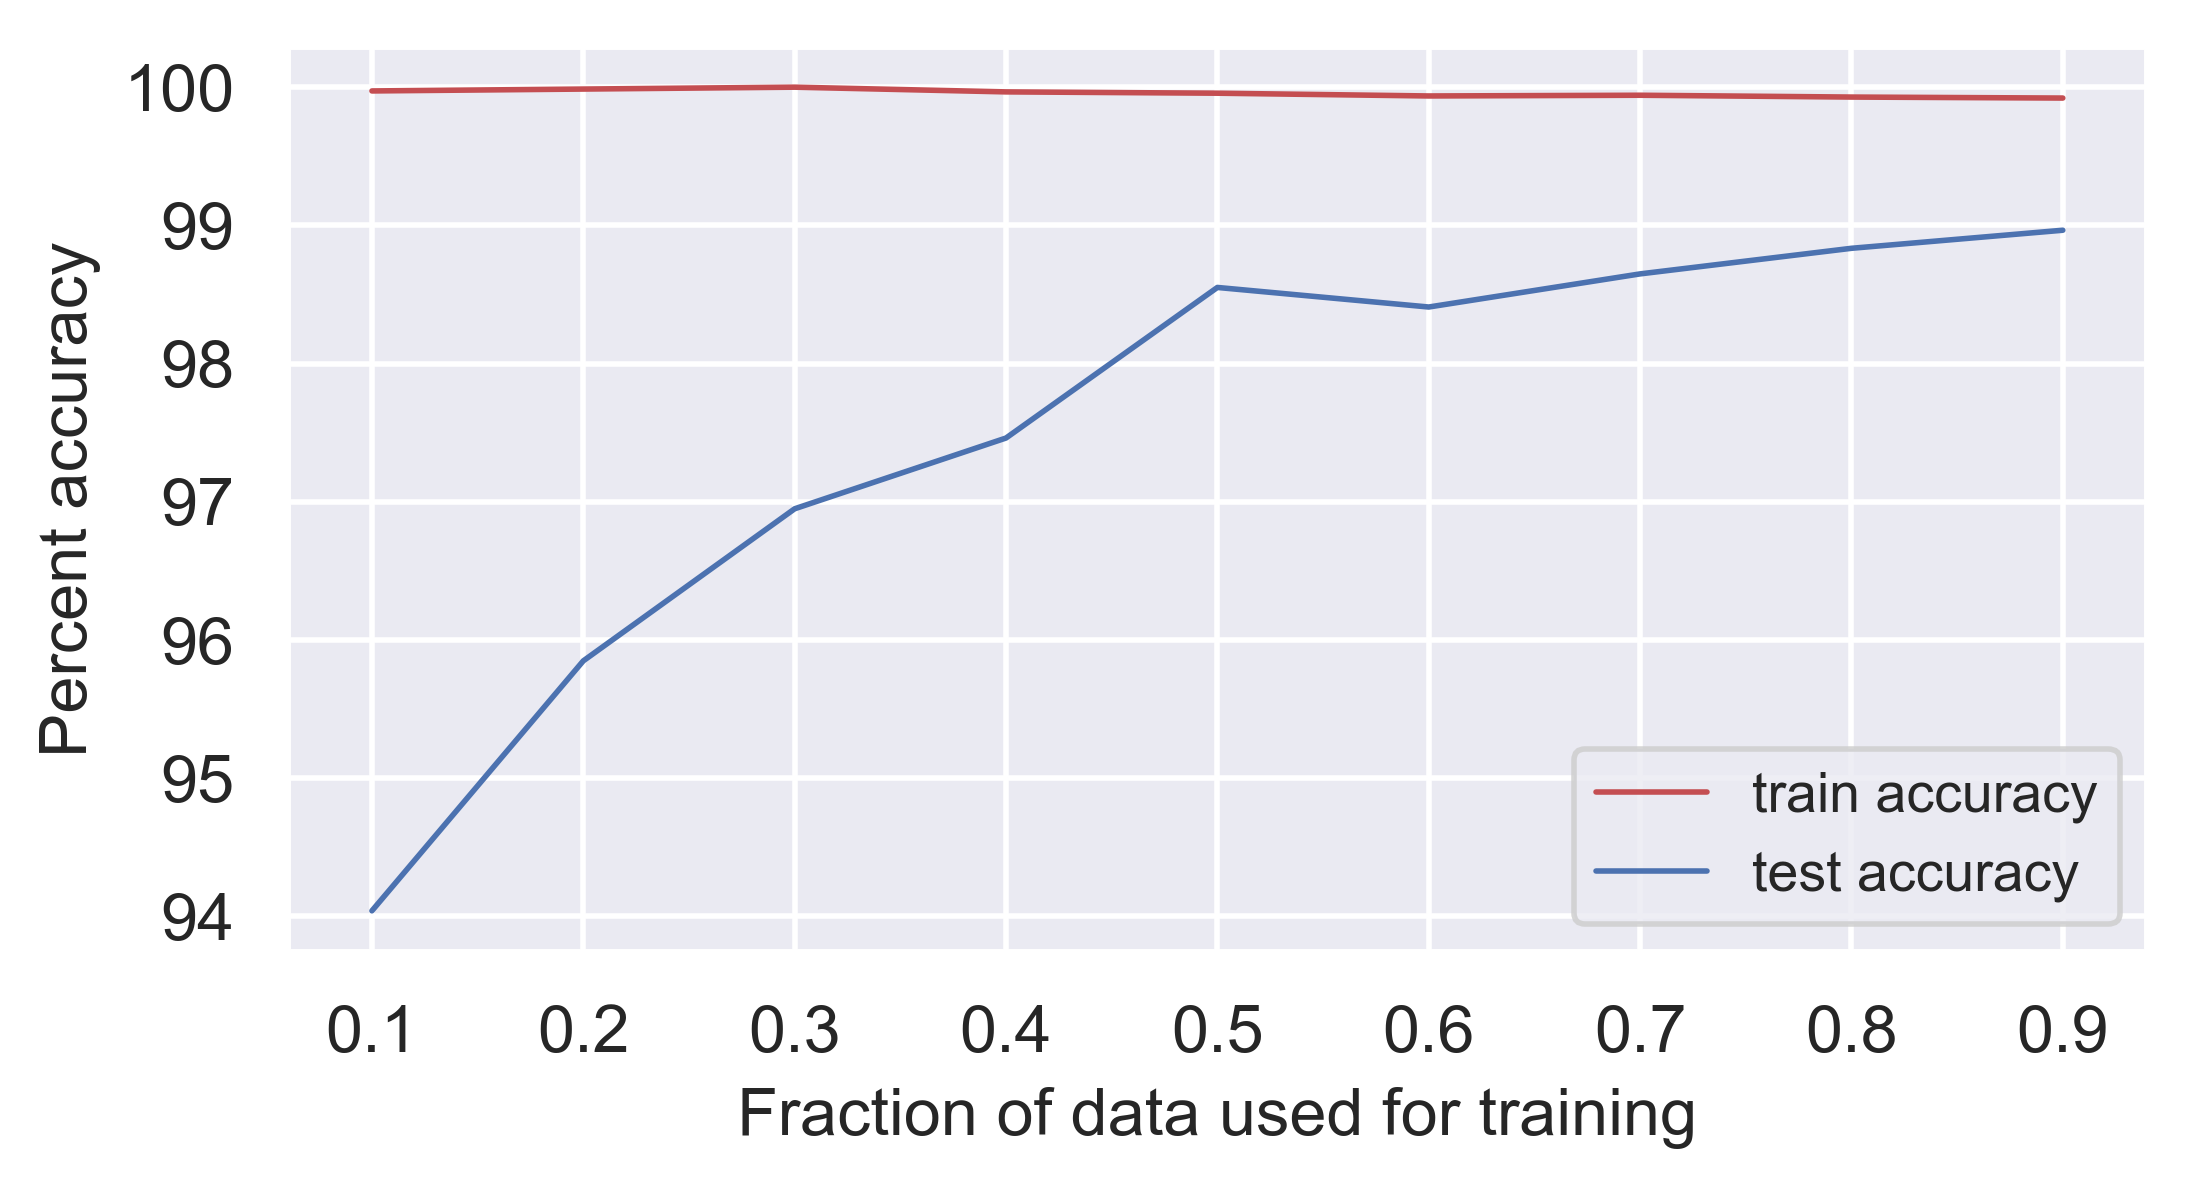

In [50]:
X = simonlyconcatX
Y = simonlyconcatY

######################
dataX, testdataX, dataY, testdataY = train_test_split(X, Y, 
                                                    test_size=0.2, 
                                                    random_state=np.random.randint(100))
datap=np.arange(.1,1,.1)
score0=[]
score1=[]
for dp in range(len(datap)):
    score2=0
    score3=0
    for r in range(Noofrun):
        dataPartision = 1.0 - datap[dp]
        trainX, testX, trainY, testY = train_test_split(dataX, dataY, 
                                                    test_size=dataPartision, 
                                                    random_state=np.random.randint(100))
        trainX = trainX.reset_index(drop=True)
        trainX = trainX.dropna()
        trainY = trainY.reset_index(drop=True)
        trainY = trainY.dropna()

        clf = tree.DecisionTreeClassifier(criterion='gini',#'entropy',#'gini', 
                                      splitter='best', 
                                      max_depth=None,#default None 
                                      min_samples_split=2, 
                                      min_samples_leaf=1, 
                                      min_weight_fraction_leaf=0.0, 
                                      max_features=None, 
                                      random_state=None, 
                                      max_leaf_nodes=None, 
                                      min_impurity_decrease=0.0, 
                                      min_impurity_split=None, 
                                      class_weight=None, 
                                      presort=False)                                             


        clf = clf.fit(trainX, trainY)
        score,precision,recall,fbeta_score,support = calc_stat(clf,trainX,trainY)
        score2 += score
        score,precision,recall,fbeta_score,support = calc_stat(clf,testdataX,testdataY)
        score3 += score
    score2 /= Noofrun
    score0.append(score2*100)
    score3 /= Noofrun
    score1.append(score3*100)

import seaborn as sns
sns.set() 
fig = plt.gcf()
fig.set_size_inches(6, 3)
fig.set_dpi(400)
plt.plot(datap,score0,label='train accuracy',linewidth=1,c='r')
plt.plot(datap,score1,label='test accuracy',linewidth=1,c='b')
plt.legend(prop={'size': 10})
# plt.grid()
plt.xlabel('Fraction of data used for training',fontsize=12)
plt.ylabel('Percent accuracy',fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#####################

In [51]:
score0

[99.97275946608553,
 99.98638158790685,
 100.0,
 99.96595396976713,
 99.95642226822093,
 99.93644741023196,
 99.94163651219797,
 99.92850333651097,
 99.92131703183634]

In [52]:
score1

[94.04074517921343,
 95.84922104804446,
 96.94955877546573,
 97.46159712386971,
 98.55104041834622,
 98.40941279006428,
 98.6490903148491,
 98.83429567491012,
 98.96502887024731]

In [16]:
1-datap

array([0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1])

(array([-0.02,  0.  ,  0.02,  0.04,  0.06,  0.08]),
 <a list of 6 Text yticklabel objects>)

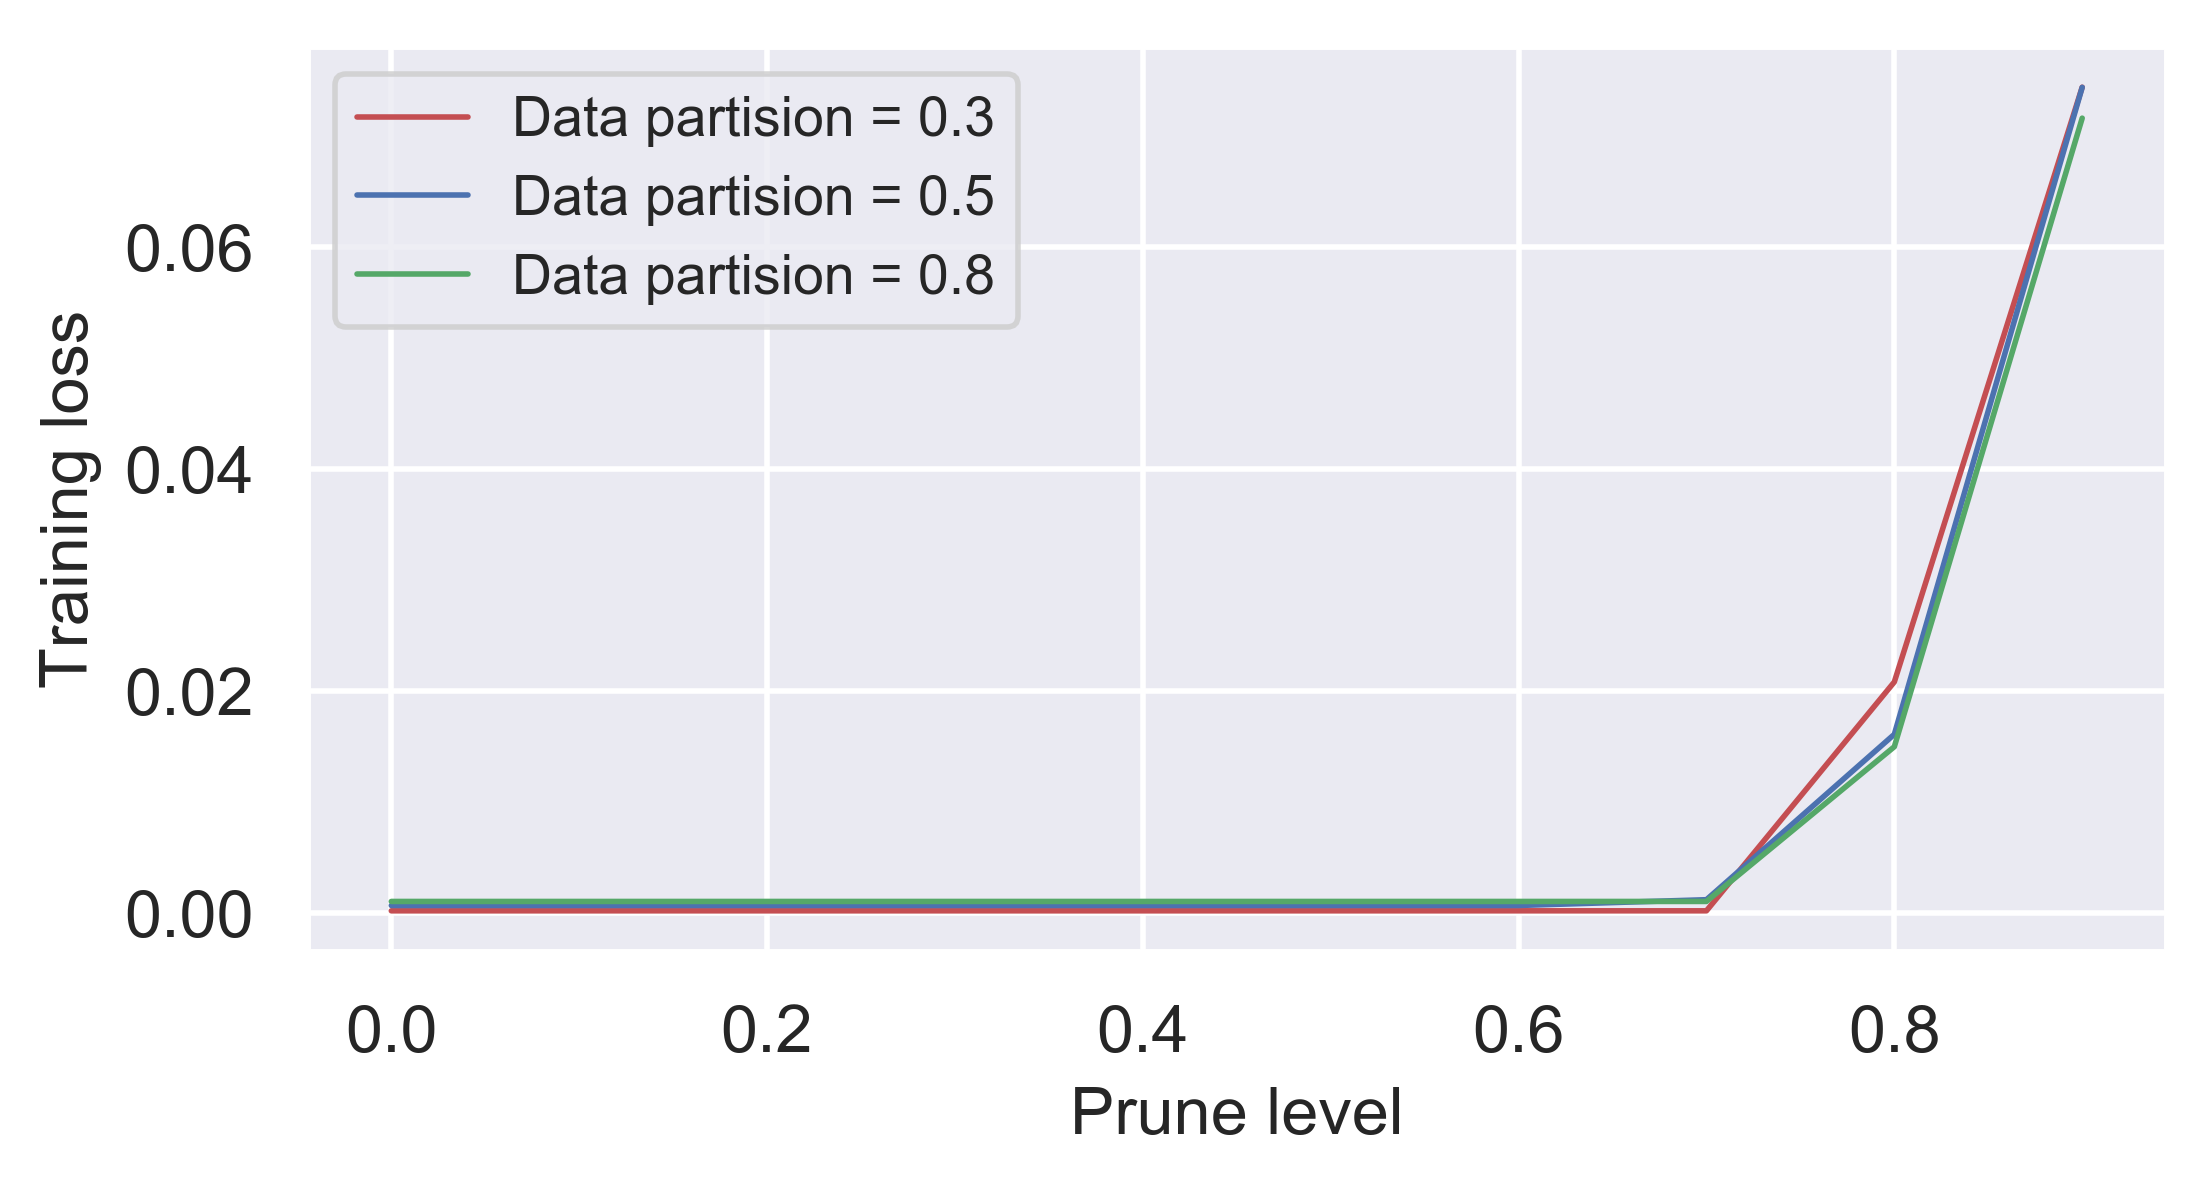

In [49]:
######################
datap=[.7,.5,.2]
prunelevel = np.arange(0.9,-.1,-.1)
score0=[]
score1=[]
for dp in range(len(datap)):
    score2=[]
    dataPartision = datap[dp]
    trainX, testX, trainY, testY = train_test_split(X,Y, 
                                                    test_size=dataPartision, 
                                                    random_state=np.random.randint(100))
    for r in range(len(prunelevel)):
        trainX = trainX.reset_index(drop=True)
        trainX = trainX.dropna()
        trainY = trainY.reset_index(drop=True)
        trainY = trainY.dropna()

        clf = tree.DecisionTreeClassifier(criterion='gini',#'entropy',#'gini', 
                                      splitter='best', 
                                      max_depth=int(100*(1-prunelevel[r])),#default None 
                                      min_samples_split=2, 
                                      min_samples_leaf=1, 
                                      min_weight_fraction_leaf=0.0, 
                                      max_features=None, 
                                      random_state=None, 
                                      max_leaf_nodes=None, 
                                      min_impurity_decrease=0.0, 
                                      min_impurity_split=None, 
                                      class_weight=None, 
                                      presort=False)                                             


        clf = clf.fit(trainX, trainY)
#         score,precision,recall,fbeta_score,support = calc_stat(clf,testX,testY)
#         score2.append(score*100)
        score,precision,recall,fbeta_score,support = calc_stat(clf,trainX,trainY)
        score2.append((1-score))
    score0.append(score2)

import seaborn as sns
sns.set() 
fig = plt.gcf()
fig.set_size_inches(6, 3)
fig.set_dpi(400)
plt.plot(prunelevel,score0[0],label='Data partision = 0.3',linewidth=1,c='r')
plt.plot(prunelevel,score0[1],label='Data partision = 0.5',linewidth=1,c='b')
plt.plot(prunelevel,score0[2],label='Data partision = 0.8',linewidth=1,c='g')
plt.legend(prop={'size': 10})
# plt.grid()
plt.xlabel('Prune level',fontsize=12)
# plt.ylabel('Prediction accuracy(%)',fontsize=12)
plt.ylabel('Training loss',fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#####################

In [39]:
prunelevel

array([9.00e-01, 8.00e-01, 7.00e-01, 6.00e-01, 5.00e-01, 4.00e-01,
       3.00e-01, 2.00e-01, 1.00e-01, 2.22e-16])